# Asset Pricing Analysis
## Time series, industry properties, determinants, univariate sorts, robustness tests

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functools import reduce
from linearmodels.panel import PanelOLS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import itertools 
from decimal import Decimal
from scipy.stats import percentileofscore

In [4]:
#import functions from functions.py
from function_definitions import *

## Analysis of the cybersecurity risk measures

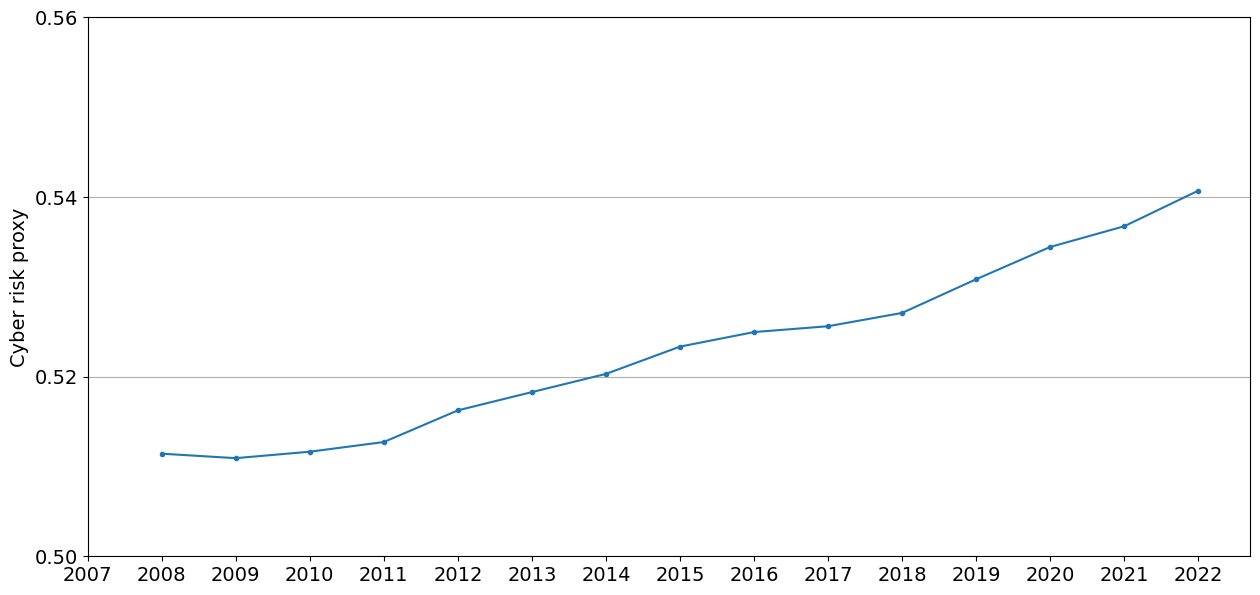

In [4]:
#plot the average of the cyber risk measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
ax = general_cybersec.mean(1).plot(style = '.-',figsize = (15,7), yticks = np.arange(0.50,0.58,0.02),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')

plt.ylabel('Cyber risk proxy', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

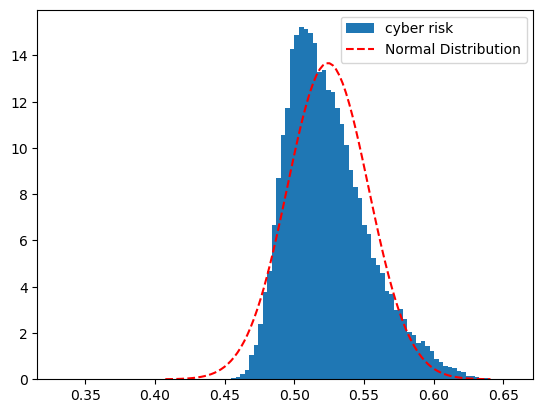

In [5]:
#plot the distribution of cyber scores
general_cybersec.stack().hist(bins = 100, density = True, label = 'cyber risk', grid = False)
# Fit a normal distribution to the data
mu, sigma = general_cybersec.stack().mean(), general_cybersec.stack().std()
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
# Calculate the corresponding y-values using the normal distribution formula
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, y, color='red', label='Normal Distribution', linestyle = '--')
plt.legend()
plt.show()

In [6]:
#Compute the skewness of the cyber risk measure
print(f'Skew = {general_cybersec.diff().stack().skew()}')
#copute the kurtosis
print(f'Kurtosis = {general_cybersec.diff().stack().kurtosis()}')

Skew = 0.7100622867386506
Kurtosis = 7.034595021463195


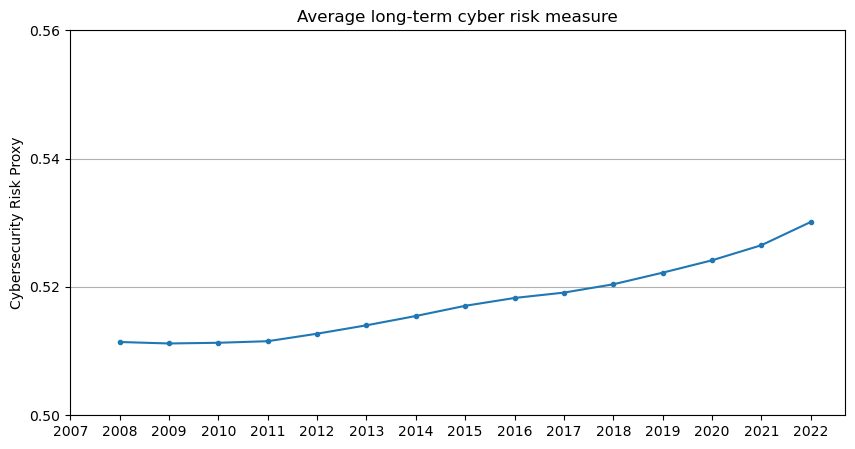

In [7]:
#plot the average of the long-term cyber risk measure
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan
ax = long_term_cybersec.mean(1).plot(style = '.-',figsize = (10,5), yticks = np.arange(0.50,0.58,0.02),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')

plt.title('Average long-term cyber risk measure')
plt.ylabel('Cybersecurity Risk Proxy')
plt.show()

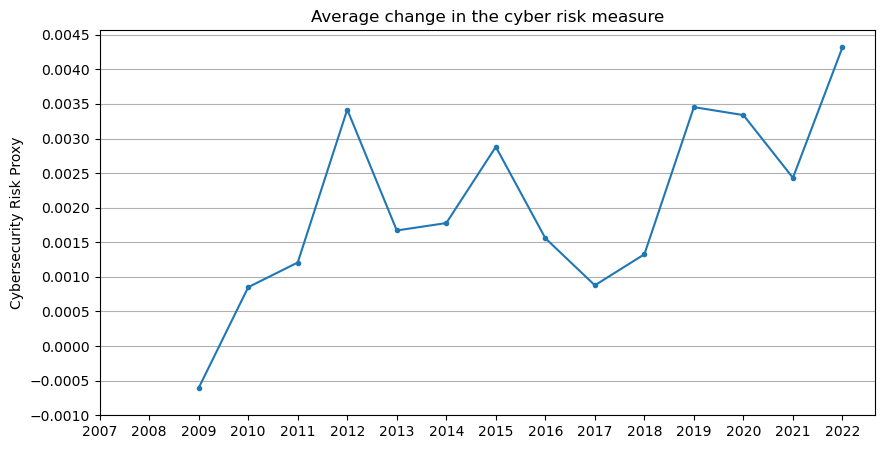

In [6]:
#plot the average of the change in the cyber risk measure
ax = general_cybersec.diff().mean(1).plot(style = '.-',figsize = (10,5), yticks = np.arange(-0.001,0.005,0.0005),
                                   xticks = np.arange(2007,2023)).grid(axis = 'y')
plt.title('Average change in the cyber risk measure')
plt.ylabel('Cybersecurity Risk Proxy')
plt.show()

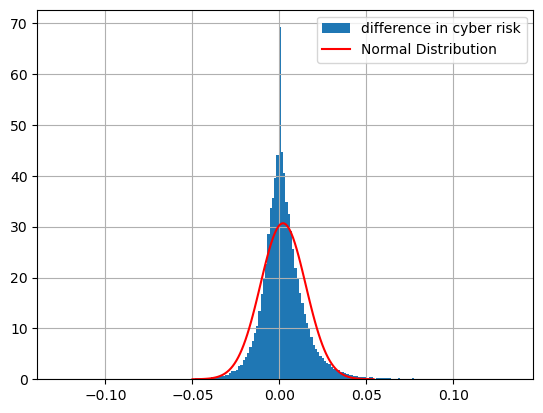

count    49903.000000
mean         0.002116
std          0.013005
min         -0.126049
1%          -0.029017
25%         -0.004561
50%          0.000818
75%          0.007795
99%          0.042289
max          0.133089
dtype: float64

In [8]:
#plot the distribution of the change in cyber scores
general_cybersec.diff().stack().hist(bins = 200, density = True, label = 'difference in cyber risk')
# Fit a normal distribution to the data
mu, sigma = general_cybersec.diff().stack().mean(), general_cybersec.diff().stack().std()
# Generate points along the x-axis for the normal distribution curve
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 100)
# Calculate the corresponding y-values using the normal distribution formula
y = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, y, color='red', label='Normal Distribution')
plt.legend()
plt.show()
p = [0.01,0.25,0.5,0.75,0.99]
general_cybersec.diff().stack().describe(percentiles = p)

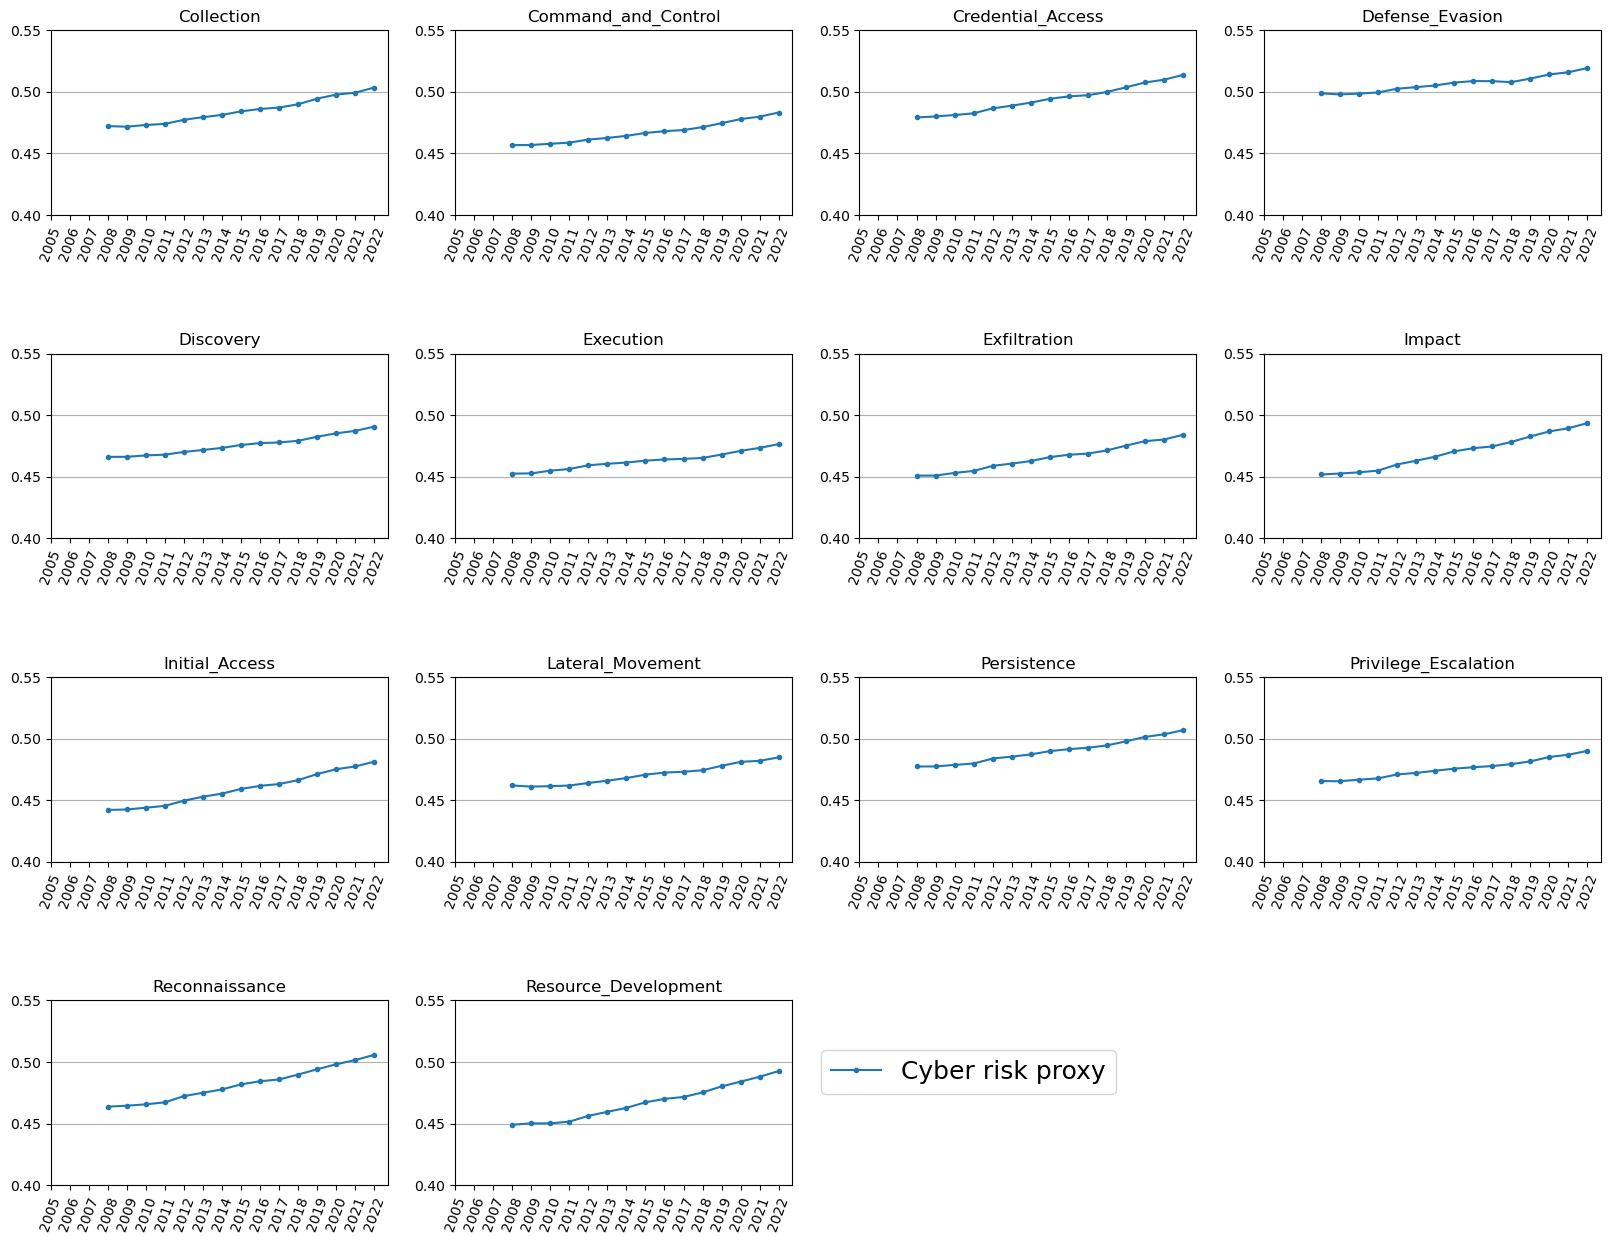

In [9]:
#plot the average of the cyber risk measures for each tactic
tactic_cybersec = pd.read_csv(cyber_measures_path+'tactic_cybersec_scores.csv.gz',header = [0,1], index_col = 0)
df = tactic_cybersec.groupby(level = 0, axis = 1).mean()

n_cols = df.shape[1]//3
n_rows = 4  

# Create the subplots and iterate over the columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
for i, col in enumerate(df.columns):
    ax = axes[i // n_cols, i % n_cols] if n_cols > 1 else axes[i]
    ax.ticklabel_format(useOffset=False, style='plain')
    df[col].plot(style = '.-',ax=ax,xticks = np.arange(2005,2023),yticks = np.arange(0.4,0.6,0.05)).grid(axis = 'y')
    ax.tick_params(axis = 'x',rotation = 70)
    ax.set_title(col)
    if (i == df.shape[1]-1):
        ax.legend(['Cyber risk proxy'], bbox_to_anchor=[1.05, 0.8],fontsize="18")
    
# Remove unused subplots in the last row
if df.shape[1] < n_rows * n_cols:
    for j in range(df.shape[1] % n_cols, n_cols):
        fig.delaxes(axes[n_rows - 1, j])

#plt.tight_layout()
plt.subplots_adjust(hspace=0.75)
plt.show()

## Cybersecurity risk by industry

In [5]:
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)

#calculate the average cybersecurity score by industry
avg_cyber_industry = []
for industry in range(1,13):
    firms = stocknames[stocknames.FF_Industry_code == industry].ticker.values
    firms = firms[np.isin(firms, general_cybersec.columns)]
    avg_cyber_industry.append(np.nanmean(general_cybersec.loc[:,firms]))

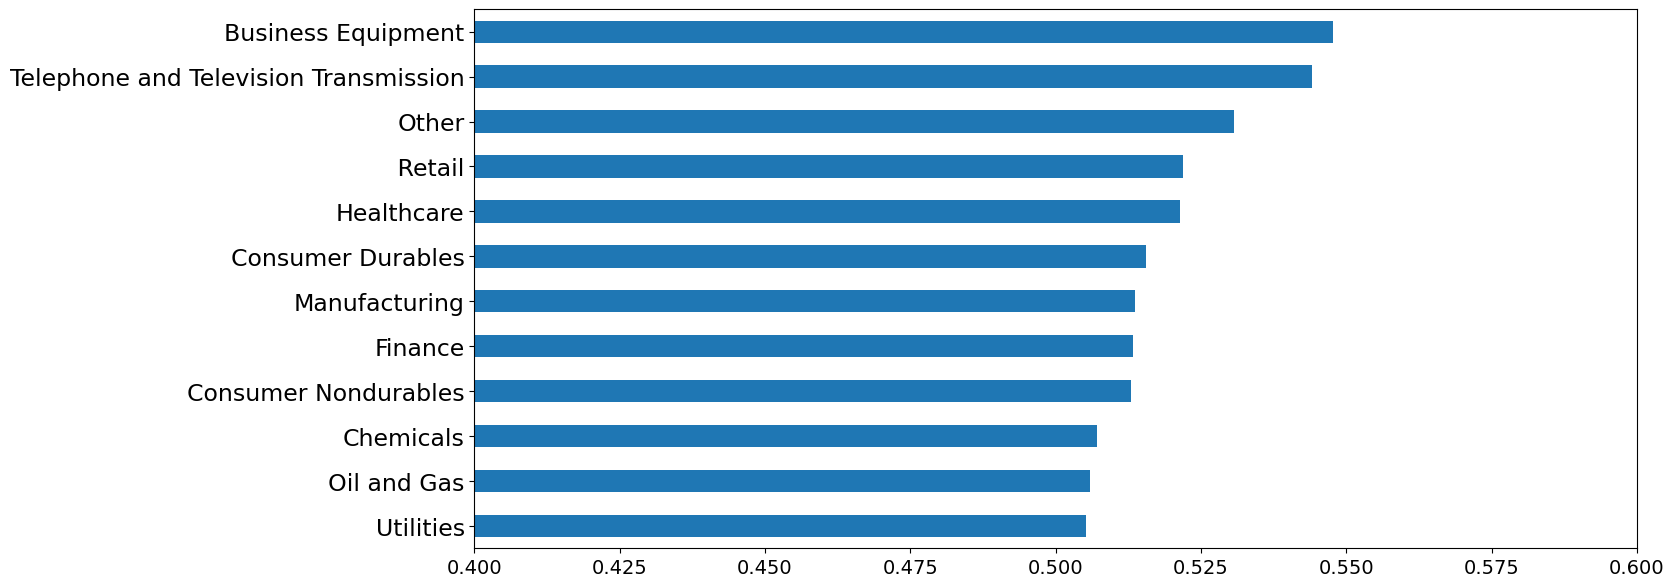

In [8]:
#plot the average cybersecurity score by industry
avg_cyber_industry = pd.DataFrame(avg_cyber_industry, index = ['Consumer Nondurables', 'Consumer Durables',
                                                                 'Manufacturing', 'Oil and Gas',
                                                                 'Chemicals', 'Business Equipment',
                                                                 'Telephone and Television Transmission',
                                                                 'Utilities', ' Retail', 'Healthcare',
                                                                 'Finance', 'Other'])
avg_cyber_industry.sort_values(0).plot.barh(legend = False, figsize = (15,7))
#plt.title('Average cybersecurity risk by industry', fontsize = 18)
plt.xlim(0.4,0.6)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 17)
plt.show()

## Descriptive Statistics

In [5]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
book_value = pd.read_csv(read_path + 'book_values.csv.gz', index_col = 'date')
book_to_market = pd.read_csv(read_path+'book_to_market.csv.gz', index_col = 'date')
total_assets = pd.read_csv(read_path + 'firm_sizes.csv.gz', index_col = 'date')
ROA = pd.read_csv(read_path+'ROA.csv.gz', index_col = 'date')
firm_age = pd.read_csv(read_path+'firm_ages.csv.gz', index_col = 'date')
TobinQ = pd.read_csv(read_path+'TobinsQ.csv.gz', index_col = 'date')
betas = pd.read_csv(read_path+'mkt_betas.csv.gz', index_col = 'date')
intangibles_to_assets = pd.read_csv(read_path+'intangibles_to_assets.csv.gz',index_col = 'date')
ratios = pd.read_csv(read_path+'fin_ratios.csv.gz')

#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)

#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan

book_value.index = pd.to_datetime(book_value.index)
book_to_market.index = pd.to_datetime(book_to_market.index)
total_assets.index = pd.to_datetime(total_assets.index)
ROA.index = pd.to_datetime(ROA.index)
firm_age.index = pd.to_datetime(firm_age.index)
TobinQ.index = pd.to_datetime(TobinQ.index)
betas.index = pd.to_datetime(betas.index)
intangibles_to_assets.index = pd.to_datetime(intangibles_to_assets.index)
ratios.date = pd.to_datetime(ratios.date)
ratios.set_index(['date','ticker'], inplace = True)

In [6]:
#limit to common firms
cols = list(reduce(set.intersection, (set(df.columns) for df in [general_cybersec,
                                                                 total_assets, firm_age,
                                                                 ROA, book_to_market,
                                                                 TobinQ, betas,
                                                                 intangibles_to_assets])))
general_cybersec = general_cybersec.loc[:,cols]
long_term_cybersec = long_term_cybersec.loc[:,cols]
book_value = book_value.loc[book_value.index.year>=2008,cols]
book_to_market = book_to_market.loc[book_to_market.index.year>=2008,cols]
total_assets = total_assets.loc[total_assets.index.year>=2008,cols]
ROA = ROA.loc[ROA.index.year>=2008,cols]
firm_age = firm_age.loc[firm_age.index.year>=2008,cols]
TobinQ = TobinQ.loc[TobinQ.index.year>=2008,cols]
betas = betas.loc[betas.index.year>=2008,cols]
intangibles_to_assets = intangibles_to_assets.loc[intangibles_to_assets.index.year>=2008,cols]

#industry classifications
industry = stocknames.loc[stocknames.ticker.isin(cols),['ticker','FF_Industry_code']]
industry = industry.set_index('ticker').T
industry = industry.loc[:,cols]
monthly_industry = pd.concat([industry]*len(total_assets))
monthly_industry.index = total_assets.index
yearly_industry = pd.concat([industry]*len(general_cybersec))
yearly_industry.index = general_cybersec.index

#ratios
idx = intangibles_to_assets.stack().index.intersection(ratios.index)
ratios = ratios.loc[idx]

In [24]:
p = [0.01,0.25,0.5,0.75,0.99]
desc_stat = pd.Series(general_cybersec.values.ravel()).describe(percentiles = p)
desc_stat = pd.concat([desc_stat,pd.Series(long_term_cybersec.values.ravel()).describe(percentiles = p)],axis = 1)
with np.errstate(invalid='ignore'):
    desc_stat = pd.concat([desc_stat,pd.Series(np.log(total_assets.values.ravel())).describe(percentiles = p)],axis = 1)
    desc_stat = pd.concat([desc_stat,pd.Series(np.log(firm_age.values.ravel())).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,pd.Series(ROA.values.ravel()).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,pd.Series(book_to_market.values.ravel()).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,pd.Series(TobinQ.values.ravel()).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,pd.Series(betas.values.ravel()).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,pd.Series(intangibles_to_assets.values.ravel()).describe(percentiles = p)],axis = 1)
desc_stat = pd.concat([desc_stat,ratios.describe(percentiles = p)],axis = 1)
desc_stat.columns = ['Cyber risk index','Long-Term Cyber Risk Index','Firm Size (ln)',
                     'Firm Age (ln)','ROA','Book To Market',"Tobin's Q", 'Market beta', 'Intagibles To Assets',
                    'Debt To Assets', 'ROE', 'Price To Earnings', 'Profit Margin',
                    'Asset Turnover', 'Cash Ratio', 'Sales To Invested Capital',
                    'Capital Ratio', 'R&D To Sales', 'ROCE']
desc_stat.T.iloc[:,1:].round(2)

,mean,std,min,1%,25%,50%,75%,99%,max
Cyber risk index,0.52,0.03,0.45,0.47,0.50,0.52,0.54,0.61,0.66
Long-Term Cyber Risk Index,0.52,0.03,0.45,0.48,0.50,0.51,0.53,0.60,0.66
Firm Size (ln),20.18,2.39,13.15,14.16,18.53,20.26,21.86,25.47,26.01
Firm Age (ln),2.70,1.06,-2.48,-0.88,2.21,2.93,3.41,4.07,4.11
ROA,-0.11,0.47,-4.34,-2.56,-0.07,0.02,0.07,0.37,0.49
Book To Market,0.68,1.15,0.00,0.02,0.24,0.46,0.80,4.40,99.55
Tobin's Q,2.20,2.14,0.41,0.58,1.09,1.50,2.37,12.16,24.00
Market beta,1.20,0.84,-3.03,-1.01,0.71,1.13,1.60,3.90,5.87
Intagibles To Assets,0.17,0.21,0.00,0.00,0.00,0.07,0.27,0.78,8.10
Debt To Assets,0.53,0.28,0.03,0.06,0.32,0.52,0.70,1.48,1.81


In [8]:
skew = pd.Series(general_cybersec.values.ravel()).skew()
print(f'The skewness of the general cyber risk measure is {round(skew,3)}')

The skewness of the general cyber risk measure is 0.767


## Determinants of cybersecurity risk

In [41]:
total_assets = total_assets.resample('Y').first()
total_assets.index = total_assets.index.to_period('Y').year.astype(int)
total_assets = total_assets.loc[total_assets.index>=2008,:]
firm_age = firm_age.resample('Y').first()
firm_age.index = firm_age.index.to_period('Y').year.astype(int)
firm_age = firm_age.loc[firm_age.index>=2008,:]
ROA = ROA.resample('Y').first()
ROA.index = ROA.index.to_period('Y').year.astype(int)
ROA = ROA.loc[ROA.index>=2008,:]
book_to_market = book_to_market.resample('Y').first()
book_to_market.index = book_to_market.index.to_period('Y').year.astype(int)
book_to_market = book_to_market.loc[book_to_market.index>=2008,:]
TobinQ = TobinQ.resample('Y').first()
TobinQ.index = TobinQ.index.to_period('Y').year.astype(int)
TobinQ = TobinQ.loc[TobinQ.index>=2008,:]
betas = betas.resample('Y').first()
betas.index = betas.index.to_period('Y').year.astype(int)
betas = betas.loc[betas.index>=2008,:]
intangibles_to_assets = intangibles_to_assets.resample('Y').first()
intangibles_to_assets.index = intangibles_to_assets.index.to_period('Y').year.astype(int)
intangibles_to_assets = intangibles_to_assets.loc[intangibles_to_assets.index>=2008,:]

In [42]:
#stack the variables
X = pd.concat([general_cybersec.stack(), np.log(total_assets.stack()), np.log(firm_age.stack()), ROA.stack(),
               book_to_market.stack(), TobinQ.stack(), betas.stack(), intangibles_to_assets.stack()], axis = 1)
X.columns = ['cybersec','firm size', 'firm age', 'ROA', 'book to market','Tobin Q','market beta','intangibles']
X.index.names = ('years','ticker')

#add financial ratios
ratios = ratios.reset_index()
ratios = ratios.groupby('ticker').resample('Y', on = 'date').first()
ratios = ratios.swaplevel().sort_index().drop(['ticker','date'], axis = 1)
ratios = ratios.reset_index() 
ratios.rename(columns = {'date':'years'}, inplace = True)
ratios.years = ratios.years.dt.year
ratios = ratios.set_index(['years','ticker'])

X = pd.concat([X, ratios], axis = 1, join = 'inner')

# standardize the variables
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index = X.index)
#merge with industry classifications
X = X.reset_index()
industries = stocknames[stocknames.ticker.isin(X.ticker)].loc[:,['ticker','FF_Industry_code']]
X = X.join(industries.set_index('ticker'), on = 'ticker')
X.set_index(['years','ticker'],inplace = True)

In [90]:
#correlation with the cyber risk measure
X.corr().cybersec

cybersec              1.000000
firm size            -0.098599
firm age             -0.175643
ROA                  -0.047755
book to market       -0.121558
Tobin Q               0.225457
market beta          -0.000963
intangibles           0.143244
debt2assets          -0.094192
ROE                  -0.063552
price2earnings       -0.008049
profit_margin        -0.002776
asset_turnover       -0.034289
cash_ratio            0.112224
sales2invested_cap   -0.006790
capital_ratio        -0.103191
r&d2sales             0.031015
ROCE                 -0.072598
FF_Industry_code      0.095597
Name: cybersec, dtype: float64

In [248]:
if type(X.index.get_level_values(0).values[0]) is not str:
    X = X.swaplevel().sort_index()
X = sm.add_constant(X)
X['Year'] = X.index.get_level_values(1)
dummy_year = pd.get_dummies(X.Year, drop_first = True)
dummy_year.index = X.index
X1 = pd.concat([X,dummy_year], axis = 1)
mod = PanelOLS(X1.cybersec, X1.loc[:,~X1.columns.isin(['cybersec','Year','FF_Industry_code'])], entity_effects=True,
               time_effects = False, drop_absorbed = True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                          PanelOLS Estimation Summary                           
Dep. Variable:               cybersec   R-squared:                        0.2944
Estimator:                   PanelOLS   R-squared (Between):              0.1024
No. Observations:               27760   R-squared (Within):               0.2944
Date:                Wed, Jun 07 2023   R-squared (Overall):              0.1337
Time:                        17:29:49   Log-likelihood                -1.458e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      332.74
Entities:                        3002   P-value                           0.0000
Avg Obs:                       9.2472   Distribution:                F(31,24727)
Min Obs:                       1.0000                                           
Max Obs:                       15.000   F-statistic (robust):             81.026
                            

In [249]:
X2 = pd.concat([X,pd.get_dummies(X.Year, drop_first = True)], axis = 1)
X2 = pd.concat([X2,pd.get_dummies(X.FF_Industry_code, prefix = 'I', drop_first = True)], axis = 1)
mod = PanelOLS(X2.cybersec, X2.loc[:,~X2.columns.isin(['cybersec','Year','FF_Industry_code'])], entity_effects=False,
               time_effects = False, drop_absorbed = True)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:               cybersec   R-squared:                        0.3921
Estimator:                   PanelOLS   R-squared (Between):              0.4207
No. Observations:               27760   R-squared (Within):               0.2453
Date:                Wed, Jun 07 2023   R-squared (Overall):              0.3921
Time:                        17:29:50   Log-likelihood                -3.277e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      425.57
Entities:                        3002   P-value                           0.0000
Avg Obs:                       9.2472   Distribution:                F(42,27717)
Min Obs:                       1.0000                                           
Max Obs:                       15.000   F-statistic (robust):             107.62
                            

/opt/anaconda3/lib/python3.9/site-packages/linearmodels/panel/model.py:1216: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## Univariate portfolio sorts

### General Cyber risk 

In [5]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'

returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)
long_term_cybersec = general_cybersec.expanding().mean()
long_term_cybersec[general_cybersec.isnull()] = np.nan

returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [6]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

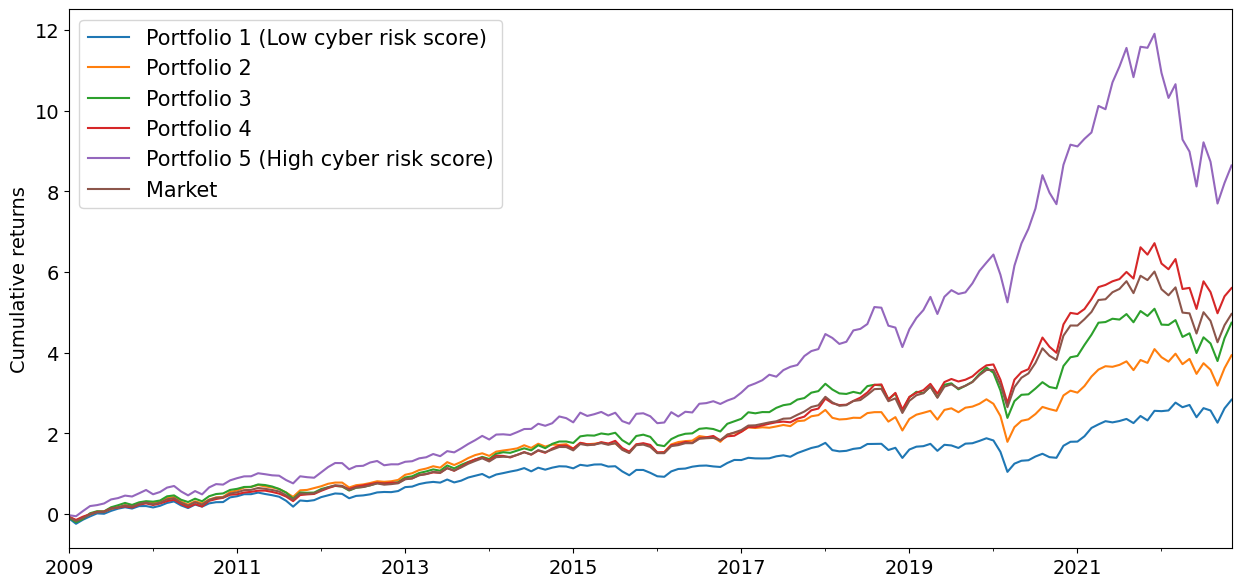

In [7]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7)) #, style = ['-',':','--','-.','--.','-x']
#plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cyber risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cyber risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

In [43]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# make a gif animation of the plot above for the presentation
temp_ = ((temp+1).cumprod())

# Set up the figure and axes
fig, ax = plt.subplots(figsize = (20,7))

# Adjust the right boundary of the plot to leave space for the legend
#plt.subplots_adjust(right=0.78)

ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Cumulative returns', fontsize = 14)
legends = ['Portfolio 1 (Low cyber risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cyber risk score)',
            'Market']
ax.set_xlim(0, len(temp_.index) - 1)
ax.set_xticks(np.linspace(0, len(temp_.index) - 1, len(temp.index.year.unique())))
ax.set_xticklabels(temp.index.year.unique(), rotation = 45)
ax.set_ylim(temp_.min().min()-0.5, temp_.max().max()+0.5)
lines = [ax.plot([], [], label = label)[0] for label in legends]
ax.legend(fontsize = 15, loc = 'upper left')# bbox_to_anchor=[1.335, 1.02]

# Function to update the plot for each frame
def update(frame):
    for i, column in enumerate(temp_.columns):
        lines[i].set_data(range(frame+1), temp_[column][:frame+1])
    return lines

# Create the animation
animation = FuncAnimation(fig, update, frames=len(temp_.index), interval=50, blit=True, repeat = False)

animation.save('../presentations/cumulative_returns.gif')
clear_output()
plt.close(fig)

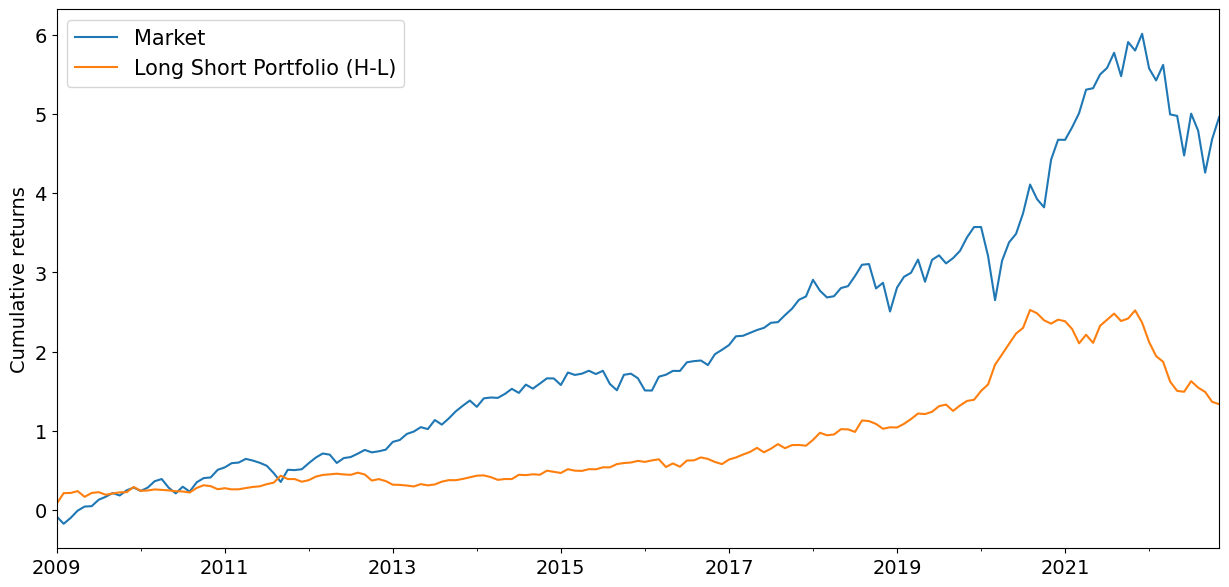

In [213]:
#plot the cumulative returns of the long-short and market portfolios
temp['LS'] = temp.quintile_4 - temp.quintile_0
((temp[['Mkt','LS']]+1).cumprod()-1).plot(figsize = (15,7))

plt.legend(['Market','Long Short Portfolio (H-L)'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

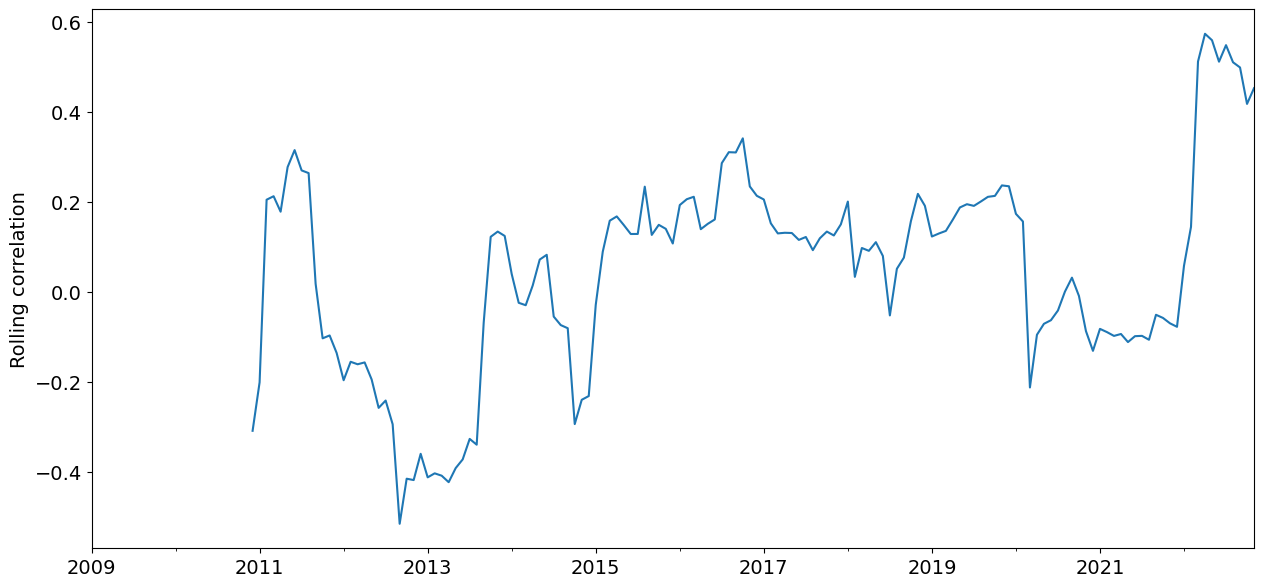

In [214]:
#plot the rolling 24 month correlation between the long-short portfolio and the market 
temp['Mkt'].rolling(window = 24).corr(temp['LS']).plot(figsize = (15,7))

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Rolling correlation', fontsize = 14)
plt.show()

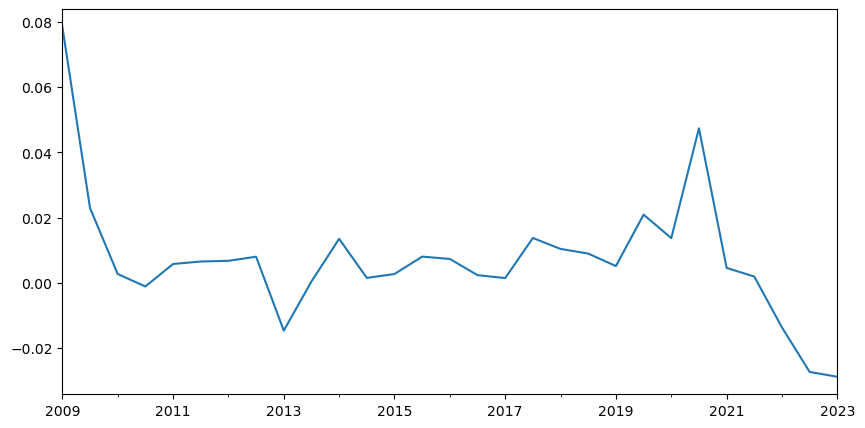

In [215]:
ax = temp.LS.resample('6M').mean().plot(figsize = (10,5))
#ax.set_xticks(temp.LS.resample('q').mean().index)
#ax.set_xticklabels(temp.LS.resample('q').mean().index.year, rotation = 45)
plt.show()

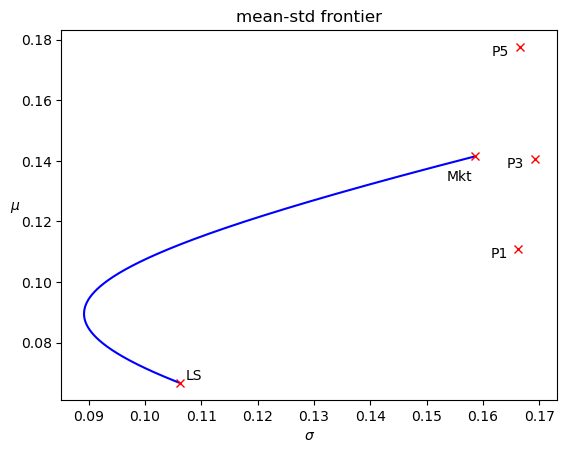

The minimum variance portfolio is 69.47% LS and 30.53% Mkt.
Its Sharpe ratio is 0.95


In [141]:
#compute the mean efficient frontier using the long-short and market portfolios
weight = np.linspace(0,1,1000)
portfolio_ret = weight*temp.LS.mean()*12 +(1-weight)*temp.Mkt.mean()*12
portfolio_std = np.sqrt(weight**2 * temp.LS.var()*12 + (1-weight)**2 * temp.Mkt.var()*12 +
                        2*weight*(1-weight)*temp.cov()['LS']['Mkt']*12)

plt.plot(portfolio_std, portfolio_ret, color = 'blue')
plt.annotate('LS', [temp.LS.std()*np.sqrt(12),temp.LS.mean()*12],
             [temp.LS.std()*np.sqrt(12)+0.001,temp.LS.mean()*12+0.001])
plt.plot(temp.LS.std()*np.sqrt(12),temp.LS.mean()*12, 'rx')
plt.annotate('Mkt', [temp.Mkt.std()*np.sqrt(12),temp.Mkt.mean()*12],
             [temp.Mkt.std()*np.sqrt(12)-0.005,temp.Mkt.mean()*12-0.008])
plt.plot(temp.Mkt.std()*np.sqrt(12),temp.Mkt.mean()*12, 'rx')

plt.annotate('P1', [temp.quintile_0.std()*np.sqrt(12),temp.quintile_0.mean()*12],
             [temp.quintile_0.std()*np.sqrt(12)-0.005,temp.quintile_0.mean()*12-0.003])
plt.plot(temp.quintile_0.std()*np.sqrt(12),temp.quintile_0.mean()*12, 'rx')
plt.annotate('P3', [temp.quintile_2.std()*np.sqrt(12),temp.quintile_2.mean()*12],
             [temp.quintile_2.std()*np.sqrt(12)-0.005,temp.quintile_2.mean()*12-0.003])
plt.plot(temp.quintile_2.std()*np.sqrt(12),temp.quintile_2.mean()*12, 'rx')
plt.annotate('P5', [temp.quintile_4.std()*np.sqrt(12),temp.quintile_4.mean()*12],
             [temp.quintile_4.std()*np.sqrt(12)-0.005,temp.quintile_4.mean()*12-0.003])
plt.plot(temp.quintile_4.std()*np.sqrt(12),temp.quintile_4.mean()*12, 'rx')

plt.title('mean-std frontier')
plt.xlabel('$\sigma$')
plt.ylabel('$\mu$').set_rotation(0)
plt.show()


rf = FF5.loc[temp.index,:].RF.mean()*12
SR = (portfolio_ret[portfolio_std.argmin()]-rf)/portfolio_std.min()
print(f'The minimum variance portfolio is {round(weight[np.argmin(portfolio_std)]*100,2)}% LS and '+
      f'{round((1-weight[np.argmin(portfolio_std)])*100,2)}% Mkt.')
print(f'Its Sharpe ratio is {round(SR,2)}')

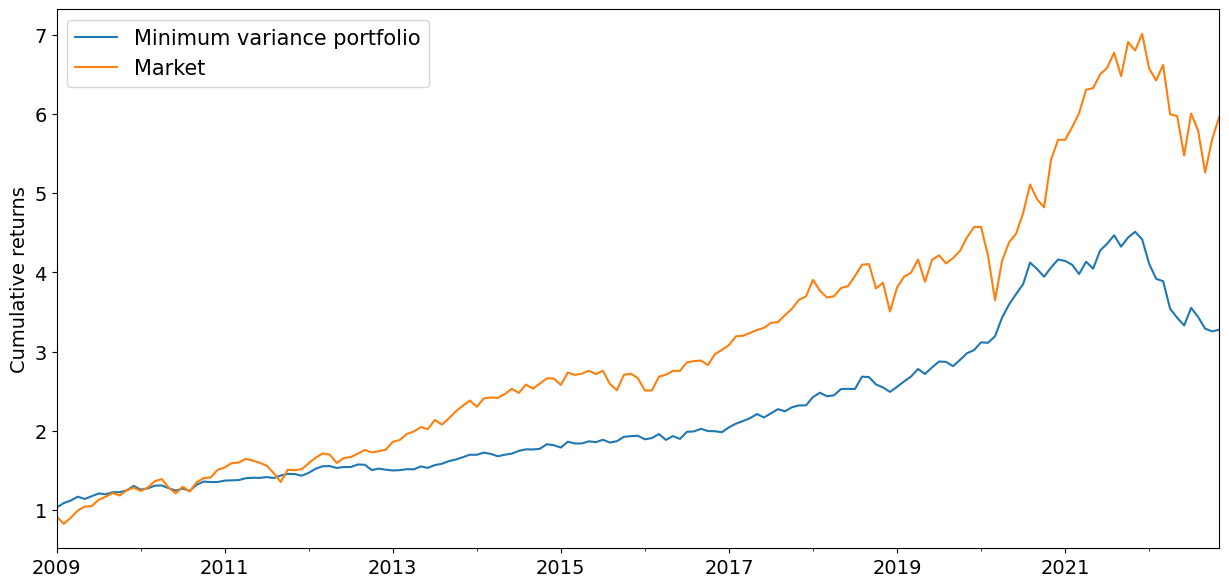

In [142]:
#plot the cumulative returns of the minimum variance portfolio
x = weight[np.argmin(portfolio_std)]
portfolio_ret = x*temp.LS +(1-x)*temp.Mkt

(1+portfolio_ret).cumprod().plot(figsize = (15,7))
(1+temp.Mkt).cumprod().plot(figsize = (15,7))
plt.legend(['Minimum variance portfolio','Market'], fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Cumulative returns', fontsize = 14)
plt.show()

In [11]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.88%,1.02%,1.13%,1.20%,1.44%,0.56%
CAPM alpha,-0.22%,-0.06%,-0.04%,0.07%,0.31%,0.54%
FFC alpha,-0.14%,-0.01%,0.03%,0.04%,0.24%,0.38%
FF5 alpha,-0.16%,-0.08%,0.03%,0.04%,0.25%,0.41%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.085
CAPM alpha,0.344,0.675,0.728,0.225,0.108,0.188
FFC alpha,0.232,0.883,0.685,0.534,0.054,0.062
FF5 alpha,0.105,0.375,0.698,0.589,0.058,0.027


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.203,3.881,3.728,4.647,4.186,1.721
CAPM alpha,-0.946,-0.420,-0.347,1.212,1.606,1.317
FFC alpha,-1.196,-0.148,0.405,0.622,1.926,1.867
FF5 alpha,-1.622,-0.887,0.388,0.540,1.894,2.215


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.6371,0.7753,0.801,0.8916,1.037,0.6282
Annualized Treynor Ratio,0.03144,0.03709,0.03796,0.0418,0.05041,3.283
Annualized Sortino Ratio,0.9416,1.199,1.263,1.462,1.79,2.733


In [12]:
#equally weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(ew_ret, FF5)
print('Equally weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Equally weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,1.36%,1.25%,1.32%,1.40%,1.45%,0.09%
CAPM alpha,0.02%,-0.11%,-0.05%,0.02%,0.07%,0.05%
FFC alpha,0.28%,0.11%,0.16%,0.23%,0.23%,-0.04%
FF5 alpha,0.23%,0.12%,0.22%,0.29%,0.28%,0.04%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.004,0.007,0.011,0.012,0.012,0.757
CAPM alpha,0.921,0.567,0.804,0.938,0.796,0.880
FFC alpha,0.005,0.178,0.150,0.150,0.195,0.789
FF5 alpha,0.087,0.299,0.166,0.134,0.193,0.776


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,2.883,2.716,2.554,2.516,2.499,0.309
CAPM alpha,0.099,-0.572,-0.249,0.078,0.258,0.151
FFC alpha,2.788,1.347,1.441,1.438,1.295,-0.267
FF5 alpha,1.713,1.039,1.385,1.500,1.301,0.285


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.7812,0.7127,0.7442,0.7773,0.8158,0.1285
Annualized Treynor Ratio,0.04017,0.03612,0.03792,0.03998,0.04158,1.472
Annualized Sortino Ratio,1.259,1.146,1.216,1.295,1.38,3.148


In [13]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cyber risk index,0.493,0.507,0.518,0.532,0.572


In [ ]:
#cybersecurity factor is calculated as Q5-Q1
CyberFactor = vw_ret.quintile_4.sub(vw_ret.quintile_0)
CyberFactor.name = 'CyberFactor'
CyberFactor.to_csv('../data/cyber_risk_measures/doc2vec/CyberFactor.csv.gz')

### Implied market price of cybersecurity

In [15]:
CyberFactor = vw_ret.quintile_4.sub(vw_ret.quintile_0)
CyberFactor.name = 'CyberFactor'

temp = pd.concat([FF5.loc[CyberFactor.index, ['Mkt-RF','SMB','HML']],CyberFactor], axis = 1)
overall_cost = 0
for firm in tqdm(returns.columns, desc = 'Estimating cost', leave = False):
    idx = returns[firm].dropna().index.intersection(CyberFactor.index)
    idx = list(reduce(set.intersection, (set(df.index) for df in [returns[firm].dropna(),mkt_caps[firm].dropna(),
                                                                  CyberFactor])))
    idx.sort()
    if len(idx) > 48:
        model = sm.OLS(returns.loc[idx,firm],sm.add_constant(temp.loc[idx])).fit() #CyberFactor
        avg_monthly_cost = model.params["CyberFactor"]*CyberFactor.loc[idx].mean()
        #if avg_monthly_cost > 0:
        overall_cost += avg_monthly_cost*mkt_caps.loc[idx,firm].mean()*12
            
clear_output()

In [16]:
print(f'{overall_cost:,}')

47,228,902,187.347755


## Before Florackis

In [40]:
#dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
dates = pd.date_range(start = '01-01-2009', end = '10-01-2020', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

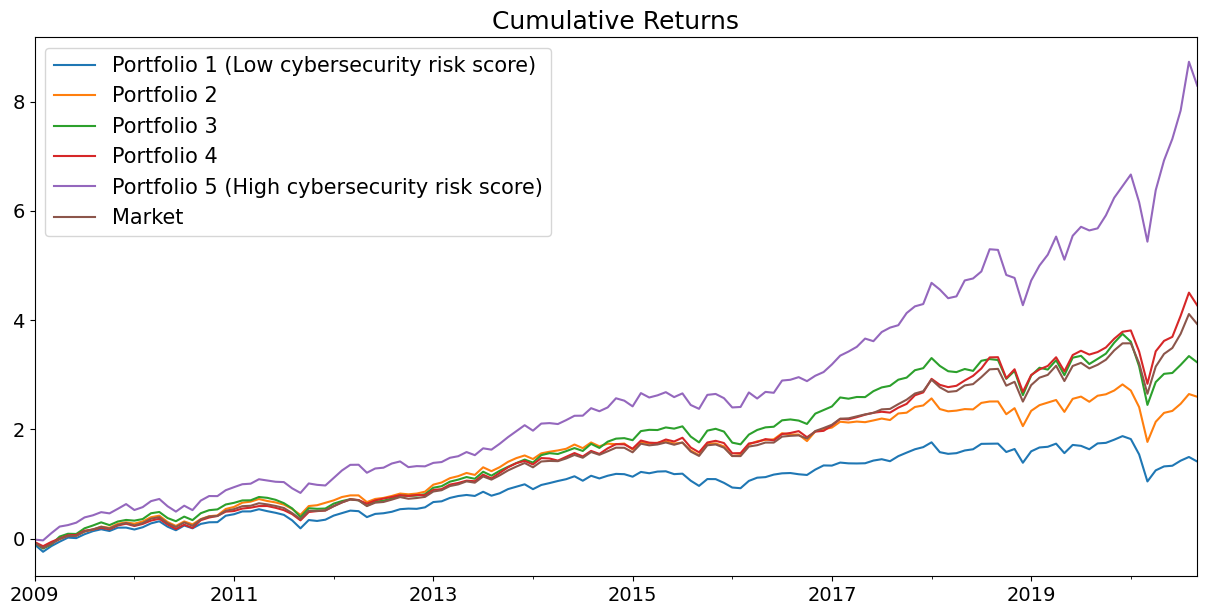

In [41]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [23]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.70%,0.97%,1.10%,1.23%,1.64%,0.94%
CAPM alpha,-0.52%,-0.20%,-0.14%,0.06%,0.51%,1.03%
FFC alpha,-0.28%,-0.06%,0.00%,-0.03%,0.27%,0.55%
FF5 alpha,-0.26%,-0.08%,0.03%,-0.06%,0.30%,0.56%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.016,0.000,0.000,0.000,0.000,0.001
CAPM alpha,0.002,0.135,0.284,0.344,0.016,0.003
FFC alpha,0.000,0.464,0.988,0.600,0.057,0.005
FF5 alpha,0.001,0.379,0.715,0.340,0.057,0.003


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,2.409,3.579,3.691,5.762,5.757,3.226
CAPM alpha,-3.115,-1.496,-1.071,0.947,2.403,2.954
FFC alpha,-3.581,-0.732,0.015,-0.524,1.907,2.831
FF5 alpha,-3.446,-0.880,0.365,-0.955,1.902,3.013


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.5107,0.7522,0.8071,0.9649,1.272,1.157
Annualized Treynor Ratio,0.02364,0.03414,0.03654,0.0433,0.05994,-0.714
Annualized Sortino Ratio,0.7233,1.137,1.257,1.571,2.393,4.319


In [24]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,600.404,599.894,599.830,599.894,600.234
Cyber risk index,0.490,0.504,0.515,0.529,0.570


In [49]:
display(vw_ret.corrwith(FF5.loc[vw_ret.index,'Mkt-RF']))
display(FF5.corrwith(vw_ret.quintile_4.sub(vw_ret.quintile_0)))

quintile_0    0.948095
quintile_1    0.967469
quintile_2    0.969491
quintile_3    0.977491
quintile_4    0.930412
dtype: float64

Mkt-RF   -0.124232
SMB      -0.160740
HML      -0.632079
RMW       0.184262
CMA      -0.438997
RF        0.098165
UMD       0.242974
dtype: float64

## After Florackis

In [25]:
#dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
dates = pd.date_range(start = '11-01-2020', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

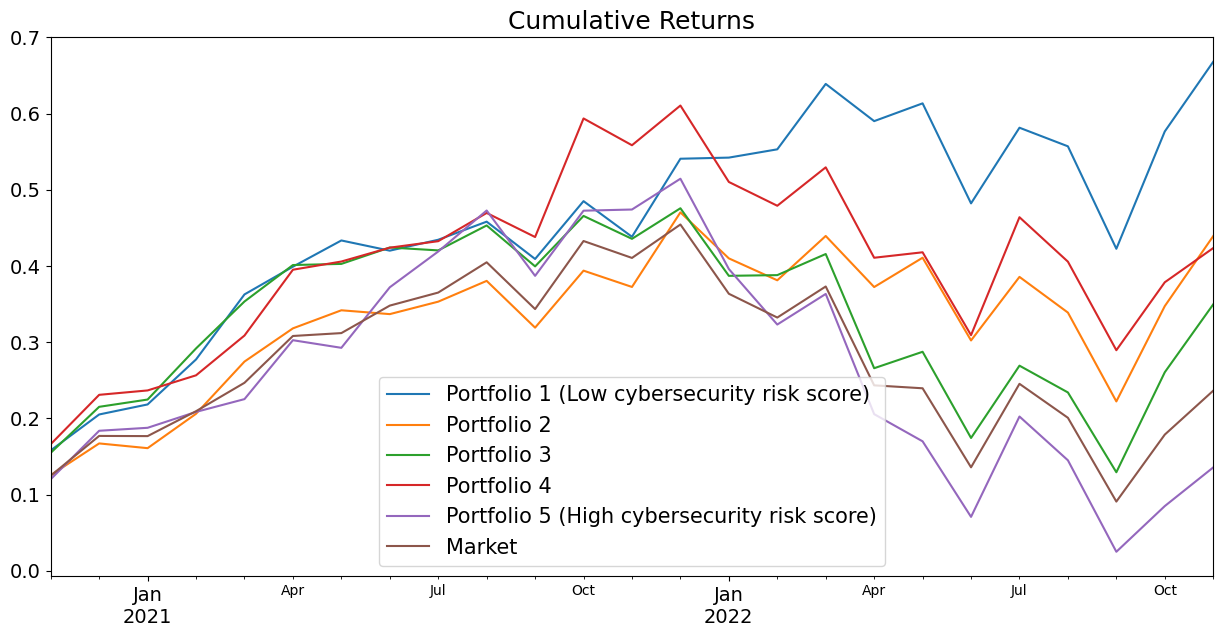

In [26]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [27]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,2.16%,1.56%,1.34%,1.55%,0.67%,-1.49%
CAPM alpha,1.34%,0.71%,0.34%,0.54%,-0.40%,-1.74%
FFC alpha,0.57%,0.19%,-0.07%,0.54%,0.17%,-0.39%
FF5 alpha,0.34%,-0.15%,-0.15%,0.65%,0.11%,-0.23%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.029,0.101,0.333,0.235,0.657,0.035
CAPM alpha,0.000,0.004,0.248,0.001,0.094,0.001
FFC alpha,0.078,0.477,0.714,0.002,0.542,0.501
FF5 alpha,0.374,0.595,0.462,0.000,0.703,0.733


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,2.183,1.641,0.969,1.188,0.444,-2.111
CAPM alpha,4.336,2.915,1.154,3.442,-1.673,-3.353
FFC alpha,1.761,0.711,-0.366,3.099,0.610,-0.673
FF5 alpha,0.889,-0.532,-0.736,3.635,0.381,-0.341


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,1.374,1.009,0.7579,0.8735,0.3569,-1.287
Annualized Treynor Ratio,0.08768,0.06114,0.04465,0.05124,0.02093,0.09242
Annualized Sortino Ratio,2.798,1.83,1.28,1.665,0.5288,0.6404


In [28]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,695.556,695.000,694.889,695.000,695.222
Cyber risk index,0.504,0.523,0.536,0.550,0.582


In [31]:
display(vw_ret.corrwith(FF5.loc[vw_ret.index,'Mkt-RF']))
display(FF5.corrwith(vw_ret.quintile_4.sub(vw_ret.quintile_0)))

quintile_0    0.891991
quintile_1    0.939051
quintile_2    0.965101
quintile_3    0.971869
quintile_4    0.971438
dtype: float64

Mkt-RF    0.353883
SMB      -0.107648
HML      -0.808038
RMW      -0.032773
CMA      -0.742779
RF       -0.078347
UMD       0.047829
dtype: float64

### Long-run cyber risk score

In [29]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
long_term_cybersec = long_term_cybersec.loc[:,(~long_term_cybersec.isnull()).sum()>3]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = long_term_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = long_term_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = long_term_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = long_term_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

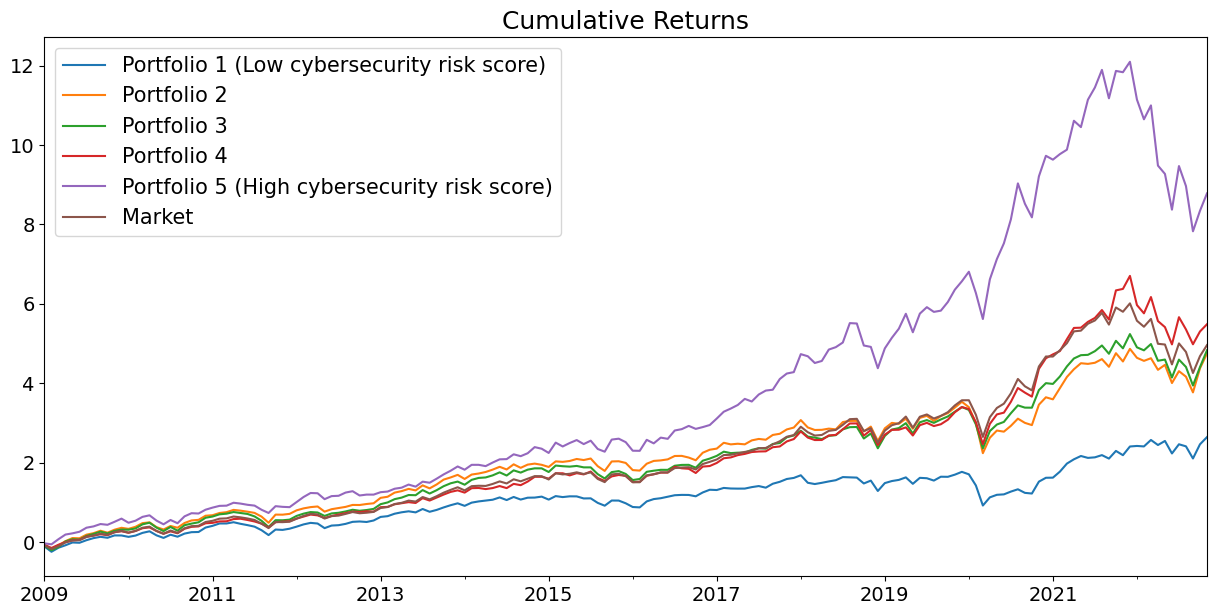

In [30]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [31]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.86%,1.13%,1.14%,1.18%,1.45%,0.60%
CAPM alpha,-0.26%,-0.01%,-0.03%,0.11%,0.31%,0.57%
FFC alpha,-0.17%,0.07%,0.05%,0.10%,0.23%,0.40%
FF5 alpha,-0.17%,0.03%,-0.01%,0.06%,0.25%,0.43%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.003,0.000,0.000,0.000,0.000,0.090
CAPM alpha,0.295,0.970,0.784,0.086,0.128,0.185
FFC alpha,0.118,0.503,0.451,0.213,0.068,0.044
FF5 alpha,0.072,0.734,0.870,0.353,0.053,0.022


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.004,3.942,3.935,4.350,4.232,1.697
CAPM alpha,-1.047,-0.037,-0.274,1.718,1.524,1.326
FFC alpha,-1.564,0.670,0.753,1.245,1.826,2.012
FF5 alpha,-1.797,0.340,-0.163,0.928,1.936,2.283


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.61,0.8182,0.8164,0.9181,1.027,0.6384
Annualized Treynor Ratio,0.03021,0.03923,0.03857,0.04364,0.05023,2.572
Annualized Sortino Ratio,0.8927,1.305,1.294,1.525,1.768,2.643


In [86]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cyber risk index,0.490,0.501,0.511,0.524,0.567


### Tactics

In [1049]:
#read in the tactic wise cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
tactic_scores = pd.read_csv(cyber_measures_path+'tactic_cybersec_scores.csv.gz', index_col = 0, header = [0,1])

Collection


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.91%,0.95%,1.18%,1.12%,1.45%,0.53%
CAPM alpha,-0.21%,-0.16%,-0.00%,-0.01%,0.32%,0.53%
FFC alpha,-0.12%,-0.08%,0.04%,-0.02%,0.25%,0.37%
FF5 alpha,-0.13%,-0.12%,0.04%,-0.03%,0.24%,0.38%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.001,0.000,0.000,0.000,0.129
CAPM alpha,0.402,0.365,0.991,0.891,0.132,0.225
FFC alpha,0.329,0.417,0.577,0.816,0.081,0.104
FF5 alpha,0.220,0.201,0.533,0.611,0.102,0.073


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.496,0.508,0.518,0.531,0.563


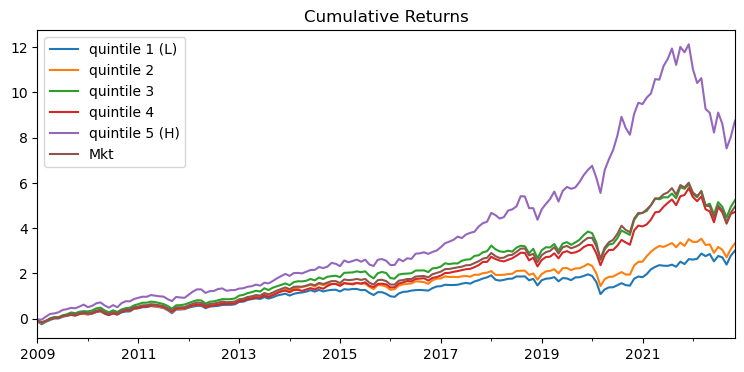

-------------------------------------------------------------------------------------------------------------------
Command_and_Control


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.95%,0.97%,1.10%,1.20%,1.49%,0.54%
CAPM alpha,-0.15%,-0.11%,-0.07%,0.02%,0.38%,0.53%
FFC alpha,-0.07%,-0.05%,-0.03%,0.02%,0.31%,0.38%
FF5 alpha,-0.12%,-0.09%,-0.04%,0.03%,0.31%,0.42%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.000,0.000,0.000,0.000,0.106
CAPM alpha,0.498,0.494,0.559,0.755,0.073,0.186
FFC alpha,0.530,0.475,0.731,0.843,0.032,0.069
FF5 alpha,0.214,0.143,0.628,0.692,0.044,0.027


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.125,615.107,615.500
Cybersecurity risk index,0.497,0.509,0.518,0.530,0.561


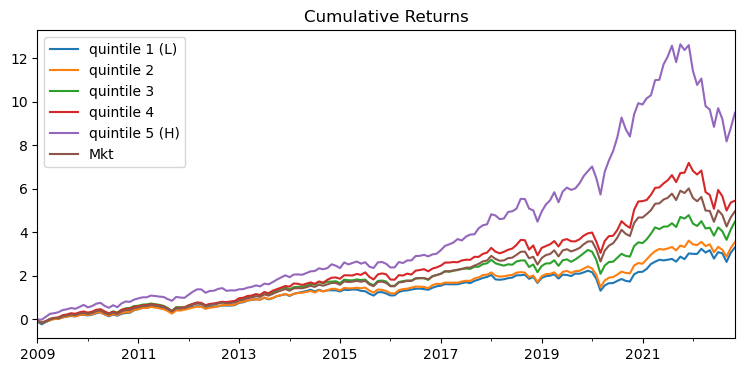

-------------------------------------------------------------------------------------------------------------------
Credential_Access


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.95%,0.94%,1.18%,1.05%,1.50%,0.55%
CAPM alpha,-0.17%,-0.13%,-0.03%,-0.07%,0.38%,0.55%
FFC alpha,-0.10%,-0.07%,0.05%,-0.08%,0.30%,0.40%
FF5 alpha,-0.14%,-0.11%,0.03%,-0.05%,0.30%,0.45%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.001,0.000,0.000,0.000,0.073
CAPM alpha,0.410,0.494,0.786,0.333,0.058,0.144
FFC alpha,0.327,0.581,0.406,0.308,0.037,0.044
FF5 alpha,0.082,0.318,0.607,0.494,0.040,0.016


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.495,0.508,0.518,0.531,0.563


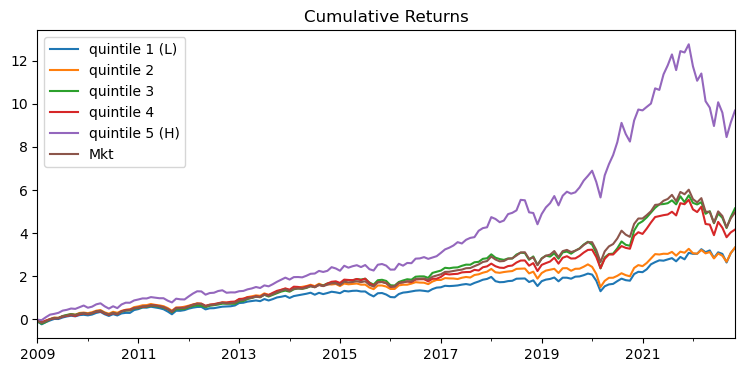

-------------------------------------------------------------------------------------------------------------------
Defense_Evasion


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.90%,1.03%,1.16%,1.14%,1.45%,0.55%
CAPM alpha,-0.22%,-0.06%,0.05%,-0.03%,0.32%,0.55%
FFC alpha,-0.14%,0.01%,0.11%,-0.02%,0.23%,0.38%
FF5 alpha,-0.15%,-0.06%,0.07%,0.01%,0.24%,0.39%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.111
CAPM alpha,0.385,0.642,0.743,0.660,0.103,0.198
FFC alpha,0.286,0.921,0.260,0.830,0.069,0.074
FF5 alpha,0.195,0.448,0.441,0.951,0.072,0.050


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.679,615.107,615.107,615.125,615.500
Cybersecurity risk index,0.494,0.508,0.518,0.531,0.563


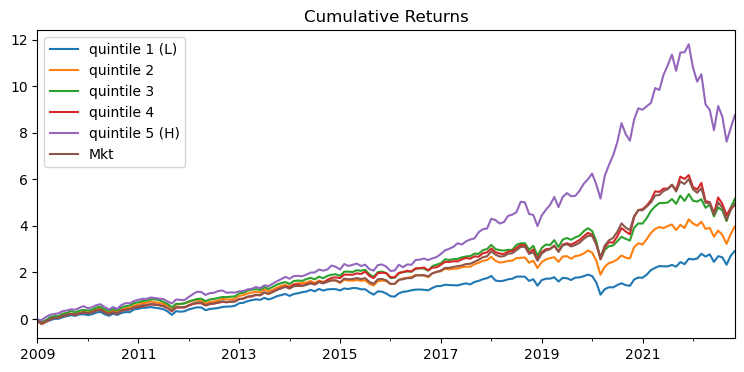

-------------------------------------------------------------------------------------------------------------------
Discovery


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.96%,0.98%,1.05%,1.18%,1.45%,0.48%
CAPM alpha,-0.17%,-0.13%,-0.06%,0.03%,0.33%,0.49%
FFC alpha,-0.07%,-0.07%,-0.00%,0.01%,0.25%,0.33%
FF5 alpha,-0.10%,-0.09%,-0.04%,0.02%,0.25%,0.35%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.122
CAPM alpha,0.489,0.353,0.664,0.676,0.077,0.217
FFC alpha,0.558,0.348,0.970,0.908,0.045,0.114
FF5 alpha,0.378,0.247,0.660,0.715,0.053,0.061


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.161,615.071,615.125,615.500
Cybersecurity risk index,0.496,0.509,0.518,0.531,0.562


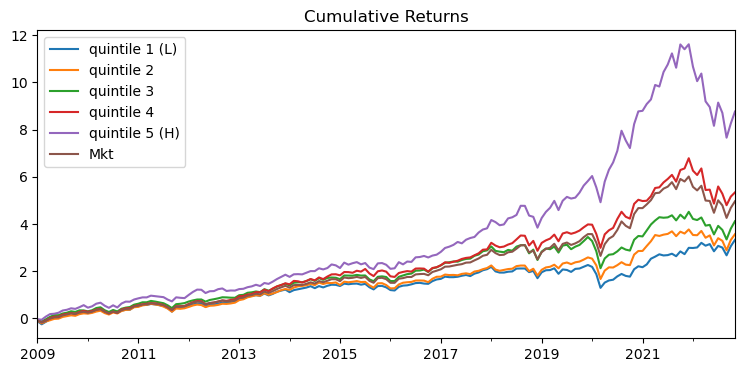

-------------------------------------------------------------------------------------------------------------------
Execution


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.89%,1.00%,1.19%,1.23%,1.38%,0.49%
CAPM alpha,-0.33%,-0.08%,0.09%,0.09%,0.26%,0.60%
FFC alpha,-0.23%,-0.02%,0.15%,0.07%,0.18%,0.41%
FF5 alpha,-0.22%,-0.05%,0.10%,0.05%,0.18%,0.41%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.003,0.000,0.000,0.000,0.000,0.120
CAPM alpha,0.159,0.607,0.484,0.144,0.175,0.147
FFC alpha,0.021,0.782,0.092,0.251,0.155,0.041
FF5 alpha,0.006,0.492,0.149,0.442,0.165,0.025


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.498,0.509,0.518,0.530,0.560


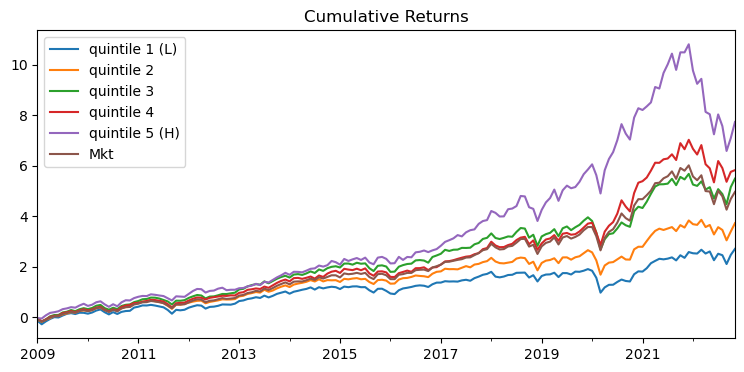

-------------------------------------------------------------------------------------------------------------------
Exfiltration


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.84%,1.05%,1.14%,1.13%,1.44%,0.60%
CAPM alpha,-0.22%,-0.09%,-0.01%,-0.06%,0.32%,0.54%
FFC alpha,-0.15%,-0.02%,0.05%,-0.05%,0.24%,0.39%
FF5 alpha,-0.20%,-0.06%,0.04%,-0.03%,0.25%,0.45%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.002,0.000,0.000,0.000,0.000,0.095
CAPM alpha,0.359,0.575,0.931,0.451,0.148,0.216
FFC alpha,0.239,0.796,0.546,0.515,0.085,0.088
FF5 alpha,0.052,0.515,0.650,0.602,0.090,0.037


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.497,0.508,0.518,0.531,0.562


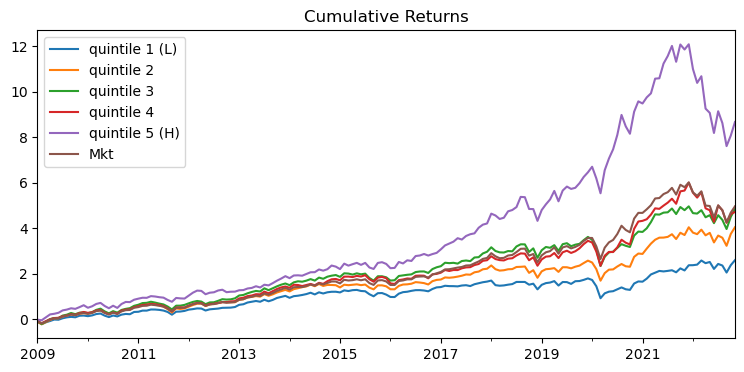

-------------------------------------------------------------------------------------------------------------------
Impact


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.88%,1.04%,1.13%,1.13%,1.47%,0.59%
CAPM alpha,-0.17%,-0.16%,-0.03%,0.04%,0.33%,0.50%
FFC alpha,-0.11%,-0.05%,-0.00%,0.04%,0.25%,0.36%
FF5 alpha,-0.17%,-0.07%,-0.02%,0.04%,0.27%,0.44%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.001,0.000,0.000,0.000,0.076
CAPM alpha,0.446,0.294,0.775,0.475,0.097,0.200
FFC alpha,0.378,0.468,0.988,0.450,0.076,0.095
FF5 alpha,0.085,0.404,0.790,0.425,0.059,0.031


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.125,615.107,615.500
Cybersecurity risk index,0.498,0.509,0.519,0.531,0.559


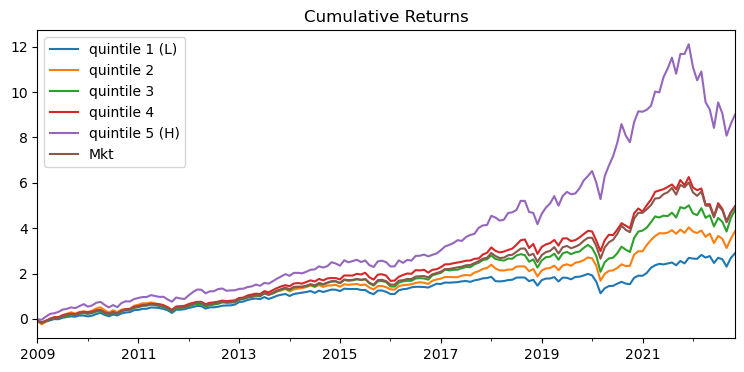

-------------------------------------------------------------------------------------------------------------------
Initial_Access


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.91%,0.94%,1.17%,1.19%,1.44%,0.52%
CAPM alpha,-0.16%,-0.16%,0.01%,-0.04%,0.34%,0.50%
FFC alpha,-0.08%,-0.09%,0.06%,-0.03%,0.26%,0.34%
FF5 alpha,-0.17%,-0.12%,0.07%,0.01%,0.27%,0.44%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.107
CAPM alpha,0.506,0.354,0.933,0.603,0.071,0.203
FFC alpha,0.565,0.251,0.491,0.689,0.038,0.100
FF5 alpha,0.136,0.067,0.465,0.889,0.041,0.026


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.497,0.508,0.518,0.530,0.562


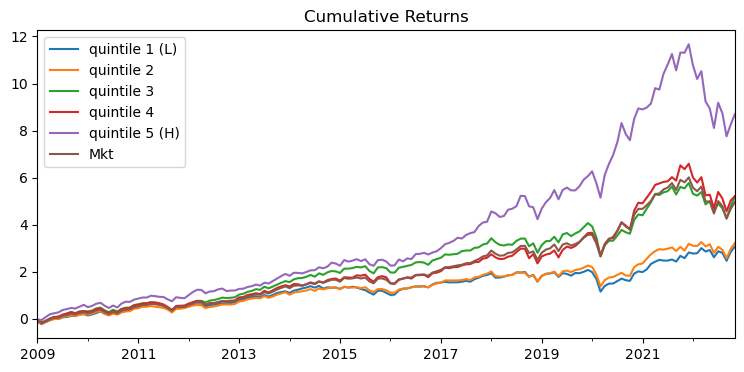

-------------------------------------------------------------------------------------------------------------------
Lateral_Movement


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.92%,1.02%,1.16%,0.99%,1.50%,0.58%
CAPM alpha,-0.15%,-0.11%,0.02%,-0.17%,0.38%,0.53%
FFC alpha,-0.08%,-0.05%,0.07%,-0.15%,0.30%,0.38%
FF5 alpha,-0.14%,-0.08%,0.08%,-0.14%,0.29%,0.43%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.000,0.000,0.001,0.000,0.070
CAPM alpha,0.491,0.490,0.908,0.011,0.061,0.182
FFC alpha,0.487,0.558,0.439,0.034,0.031,0.073
FF5 alpha,0.152,0.235,0.333,0.024,0.041,0.028


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.732,615.054,615.107,615.143,615.482
Cybersecurity risk index,0.497,0.509,0.518,0.530,0.562


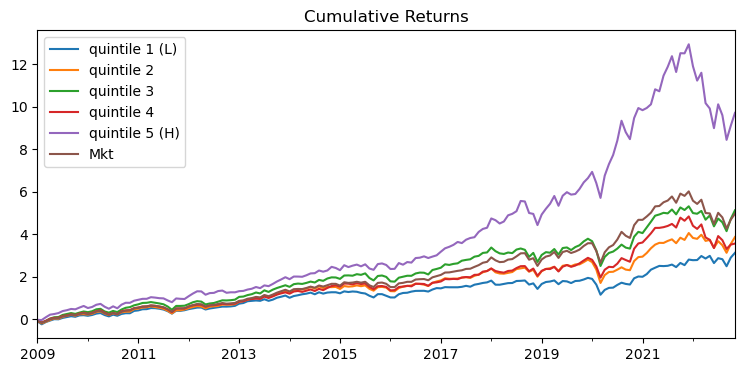

-------------------------------------------------------------------------------------------------------------------
Persistence


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.94%,0.95%,1.16%,1.12%,1.48%,0.53%
CAPM alpha,-0.13%,-0.18%,-0.00%,0.03%,0.32%,0.45%
FFC alpha,-0.07%,-0.10%,0.07%,0.04%,0.24%,0.30%
FF5 alpha,-0.12%,-0.13%,0.07%,0.01%,0.28%,0.40%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.002,0.000,0.000,0.000,0.117
CAPM alpha,0.566,0.356,0.983,0.733,0.100,0.263
FFC alpha,0.580,0.355,0.332,0.726,0.051,0.145
FF5 alpha,0.184,0.200,0.317,0.922,0.031,0.035


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.496,0.508,0.518,0.531,0.563


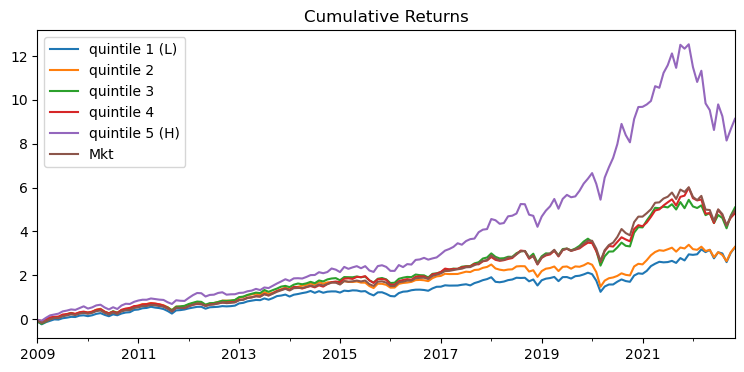

-------------------------------------------------------------------------------------------------------------------
Privilege_Escalation


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.90%,1.02%,1.13%,1.20%,1.43%,0.54%
CAPM alpha,-0.24%,-0.12%,0.02%,0.06%,0.32%,0.56%
FFC alpha,-0.16%,-0.03%,0.06%,0.07%,0.23%,0.39%
FF5 alpha,-0.17%,-0.05%,0.07%,0.05%,0.23%,0.40%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.105
CAPM alpha,0.300,0.450,0.805,0.423,0.118,0.182
FFC alpha,0.154,0.710,0.387,0.425,0.080,0.071
FF5 alpha,0.059,0.473,0.290,0.502,0.078,0.035


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.497,0.509,0.518,0.530,0.561


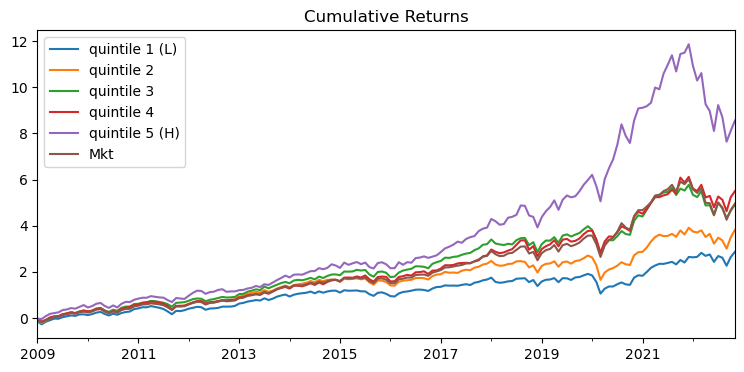

-------------------------------------------------------------------------------------------------------------------
Reconnaissance


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.90%,0.98%,1.03%,1.24%,1.42%,0.52%
CAPM alpha,-0.12%,-0.21%,-0.20%,0.12%,0.32%,0.44%
FFC alpha,-0.06%,-0.13%,-0.15%,0.10%,0.26%,0.32%
FF5 alpha,-0.14%,-0.15%,-0.09%,0.09%,0.26%,0.41%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.000,0.001,0.002,0.000,0.000,0.056
CAPM alpha,0.537,0.270,0.008,0.062,0.053,0.171
FFC alpha,0.563,0.181,0.075,0.111,0.032,0.063
FF5 alpha,0.078,0.098,0.239,0.123,0.041,0.025


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.679,615.107,615.107,615.125,615.500
Cybersecurity risk index,0.496,0.508,0.519,0.531,0.561


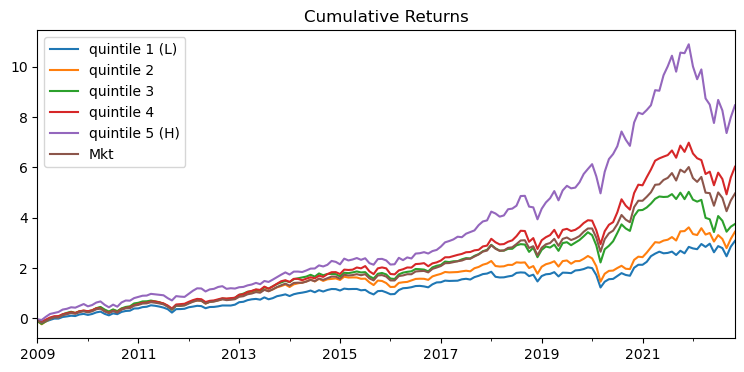

-------------------------------------------------------------------------------------------------------------------
Resource_Development


Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.87%,1.05%,1.18%,1.28%,1.38%,0.51%
CAPM alpha,-0.17%,-0.13%,-0.02%,0.13%,0.28%,0.45%
FFC alpha,-0.10%,-0.06%,0.02%,0.10%,0.23%,0.33%
FF5 alpha,-0.17%,-0.06%,0.03%,0.05%,0.25%,0.42%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.001,0.000,0.000,0.000,0.125
CAPM alpha,0.493,0.293,0.809,0.104,0.129,0.248
FFC alpha,0.466,0.443,0.839,0.207,0.066,0.096
FF5 alpha,0.143,0.468,0.679,0.488,0.072,0.035


,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,615.661,615.125,615.107,615.125,615.500
Cybersecurity risk index,0.497,0.508,0.518,0.531,0.561


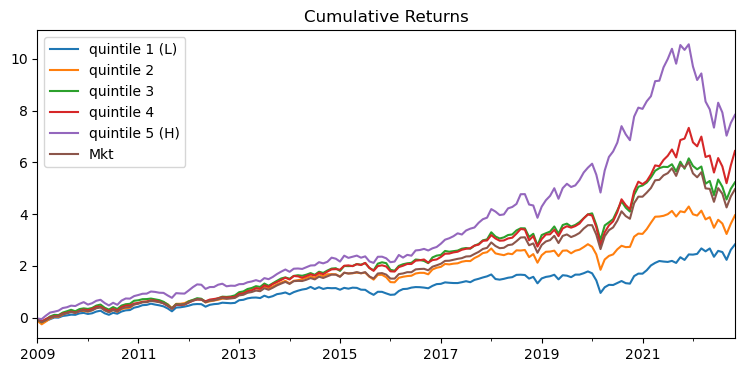

-------------------------------------------------------------------------------------------------------------------


In [1052]:
for tactic in tactic_scores.columns.levels[0]:
    tactic_cybersec = tactic_scores[tactic]
    print(tactic)
    print('\n')
    dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
    quarters = dates[::3]
    nb_firms = []
    mkt_values = []
    book_to_markets = []
    ROAs = []
    risk_index_quintiles = []

    #drop firms with less than 3 years (table 7 caption)
    tactic_cybersec = tactic_cybersec.loc[:,(~tactic_cybersec.isnull()).sum()>3]

    ew_ret = {}
    vw_ret = {}
    for i,month in enumerate(dates):
        #update every quarter
        if(month in quarters):
            #Cyber scores for the year
            Cybersec = tactic_cybersec.loc[month.year,:].dropna()
            #drop firms with no mkt cap the previous month or no ret the next 4 months
            mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
            Cybersec = Cybersec.loc[mkt_caps_.index]
            try:
                firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
            except:
                firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
            mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
            Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

            #get filling dates
            fd_col = 'filling_date_{}'.format(month.year)
            fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
            fd = fd.loc[Cybersec.index.values]
            fd[fd_col] = pd.to_datetime(fd[fd_col])

            #firms that have not filled yet
            idx_not_filled = fd[fd[fd_col] >= month].index
            #take the previous year's cyber score
            Cybersec.loc[idx_not_filled] = tactic_cybersec.loc[month.year-1,idx_not_filled]
            Cybersec.dropna(inplace = True)
            mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

            #sort firms into quintiles
            quintiles = pd.qcut(Cybersec, q = 5, labels = False)

            quantile_weights = []
            for q in range(5):
                firms = quintiles[quintiles == q].index
                quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
                nb_firms.append(len(firms))

        ew_ret[month] = []
        vw_ret[month] = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_ret = returns.loc[month, firms]
            #equally weighted portfolios
            ew_ret[month].append(quantile_ret.mean())
            #value weighted portfolios
            vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())

            #get current risk index of the portfolio
            cyber = general_cybersec.loc[month.year,firms]
            #get filling dates
            fd_col = 'filling_date_{}'.format(month.year)
            fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
            fd = fd.loc[firms]
            fd[fd_col] = pd.to_datetime(fd[fd_col])
            #firms that have not filled yet
            idx_not_filled = fd[fd[fd_col] >= month].index
            #take the previous year's cyber score
            cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
            risk_index_quintiles.append(cyber.mean())

    idx = ['quintile_'+str(i) for i in range(5)]
    ew_ret = pd.DataFrame(ew_ret, index = idx).T
    vw_ret = pd.DataFrame(vw_ret, index = idx).T
    risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
    nb_firms = np.reshape(nb_firms,(-1,5))
    
    #value weighted excess returns and alphas
    table, pval_table, *_ = get_alphas(vw_ret, FF5)
    print('Value weighted portfolios')
    display(table.style.format("{:.2%}"))
    print('p-values:')
    display(pval_table.style.format("{:.3f}"))
    
    #equally weighted excess returns and alphas
    #table, pval_table = get_alphas(ew_ret, FF5)
    #print('Equally weighted portfolios')
    #display(table.style.format("{:.2%}"))
    #print('p-values:')
    #display(pval_table.style.format("{:.3f}"))
    
    #characteristics of the portfolios
    tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cybersecurity risk index'],
                          columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
    tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
    tableB.loc['Cybersecurity risk index',:] = np.mean(risk_index_quintiles, axis = 0)
    display(tableB.style.format("{:.3f}"))
    
    #plot the cumulative return of the quintile protfolios and the market portfolio
    temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
    ((temp+1).cumprod()-1).plot(figsize = (9,4))
    plt.title('Cumulative Returns')
    plt.legend(['quintile 1 (L)', 'quintile 2', 'quintile 3', 'quintile 4', 'quintile 5 (H)', 'Mkt'])
    plt.show()
    
    print('-'*115)

good ones: credential access, lateral movement, Reconnaisance, initial access

## Exclude cyber security firms

In [32]:
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)

#read in the holdings of the HACK ETF
HACK_holdings = pd.read_csv('../data/HACK_fund_holdings.csv')
#identify firms that are in my sample
cyber_firms = HACK_holdings.loc[HACK_holdings.StockTicker.isin(stocknames.ticker),'StockTicker'].values

In [33]:
#read in the necessary files (firm characteristics)
read_path = '../data/returns/'
mkt_caps = pd.read_csv(read_path+'monthly_mkt_caps.csv.gz', index_col = 'date')
returns = pd.read_csv(read_path+'monthly_returns.csv.gz', index_col = 'date')
#read in the previously saved stocknames file
stocknames = pd.read_csv("../data/stocknames.csv.gz", na_filter = False)
stocknames.replace('', np.nan, inplace = True)
stocknames.FF_Industry_code = stocknames.FF_Industry_code.astype(float)
#read in the general cybersecurity measure
cyber_measures_path = '../data/cyber_risk_measures/doc2vec/'
general_cybersec = pd.read_csv(cyber_measures_path+'general_cybersec_scores.csv.gz', index_col = 0)


returns.index = pd.to_datetime(returns.index)
mkt_caps.index = pd.to_datetime(mkt_caps.index)

#Factor returns
FF5 = pd.read_csv('../data/FF_factors/FF5.csv',skiprows = 3, index_col = 0)[:714].astype(float)
FF5 = FF5/100 # in percent?????
FF5.index.rename('date', inplace = True)
FF5.index = pd.to_datetime(FF5.index, format = '%Y%m')
momentum = pd.read_csv('../data/FF_factors/Momentum.csv',skiprows = 13, index_col = 0)[:1153].astype(float)
momentum = momentum/100 # in percent?????
momentum.index.rename('date', inplace = True)
momentum.index = pd.to_datetime(momentum.index, format = '%Y%m')
momentum.columns = ['UMD']
FF5 = FF5.merge(momentum,left_index = True,right_index = True)

In [34]:
#Average cyber security score of the cyber security firms
avg_cyber_score = general_cybersec.loc[:,cyber_firms].mean().mean()
print(f'Average cyber score of the cyber security firms is '+ 
      f'{round(avg_cyber_score,4)}')

percentile = percentileofscore(general_cybersec.stack(), avg_cyber_score)
print(f'This corresponds to the {round(percentile, 4)}th percentile of cyber security risk')

Average cyber score of the cyber security firms is 0.5907
This corresponds to the 97.1085th percentile of cyber security risk


In [35]:
dates = pd.date_range(start = '01-01-2009', end = '12-01-2022', freq = 'MS', inclusive = 'left')
quarters = dates[::3]
nb_firms = []
mkt_values = []
book_to_markets = []
ROAs = []
risk_index_quintiles = []

#drop firms with less than 3 years (table 7 caption)
general_cybersec = general_cybersec.loc[:,(~general_cybersec.isnull()).sum()>3]

#drop cyber security firms
general_cybersec = general_cybersec.loc[:,~general_cybersec.columns.isin(cyber_firms)]

ew_ret = {}
vw_ret = {}
for i,month in enumerate(dates):
    #update every quarter
    if(month in quarters):
        #Cyber scores for the year
        Cybersec = general_cybersec.loc[month.year,:].dropna()
        #drop firms with no mkt cap the previous month or no ret the next 4 months
        mkt_caps_ = mkt_caps.loc[dates[i-1],Cybersec.index].dropna()
        Cybersec = Cybersec.loc[mkt_caps_.index]
        try:
            firms_with_ret = returns.loc[month:dates[i+4]].dropna(axis = 1,how = 'any').columns
        except:
            firms_with_ret = returns.loc[month:dates[i+1]].dropna(axis = 1,how = 'any').columns
        mkt_caps_ = mkt_caps_[mkt_caps_.index.isin(firms_with_ret)]
        Cybersec = Cybersec[Cybersec.index.isin(firms_with_ret)]

        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[Cybersec.index.values]
        fd[fd_col] = pd.to_datetime(fd[fd_col])

        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        Cybersec.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        Cybersec.dropna(inplace = True)
        mkt_caps_ = mkt_caps_.loc[mkt_caps_.index.isin(Cybersec.index)]

        #sort firms into quintiles
        quintiles = pd.qcut(Cybersec, q = 5, labels = False)

        quantile_weights = []
        for q in range(5):
            firms = quintiles[quintiles == q].index
            quantile_weights.append(mkt_caps_.loc[firms].div(mkt_caps_.loc[firms].sum()))
            nb_firms.append(len(firms))
    
    ew_ret[month] = []
    vw_ret[month] = []
    for q in range(5):
        firms = quintiles[quintiles == q].index
        quantile_ret = returns.loc[month, firms]
        #equally weighted portfolios
        ew_ret[month].append(quantile_ret.mean())
        #value weighted portfolios
        vw_ret[month].append(quantile_ret.multiply(quantile_weights[q]).sum())
        
        #get current risk index of the portfolio
        cyber = general_cybersec.loc[month.year,firms]
        #get filling dates
        fd_col = 'filling_date_{}'.format(month.year)
        fd = stocknames[[fd_col, 'ticker']].set_index('ticker')
        fd = fd.loc[firms]
        fd[fd_col] = pd.to_datetime(fd[fd_col])
        #firms that have not filled yet
        idx_not_filled = fd[fd[fd_col] >= month].index
        #take the previous year's cyber score
        cyber.loc[idx_not_filled] = general_cybersec.loc[month.year-1,idx_not_filled]
        risk_index_quintiles.append(cyber.multiply(quantile_weights[q]).sum())

idx = ['quintile_'+str(i) for i in range(5)]
ew_ret = pd.DataFrame(ew_ret, index = idx).T
vw_ret = pd.DataFrame(vw_ret, index = idx).T
risk_index_quintiles = np.reshape(risk_index_quintiles,(-1,5))
nb_firms = np.reshape(nb_firms,(-1,5))

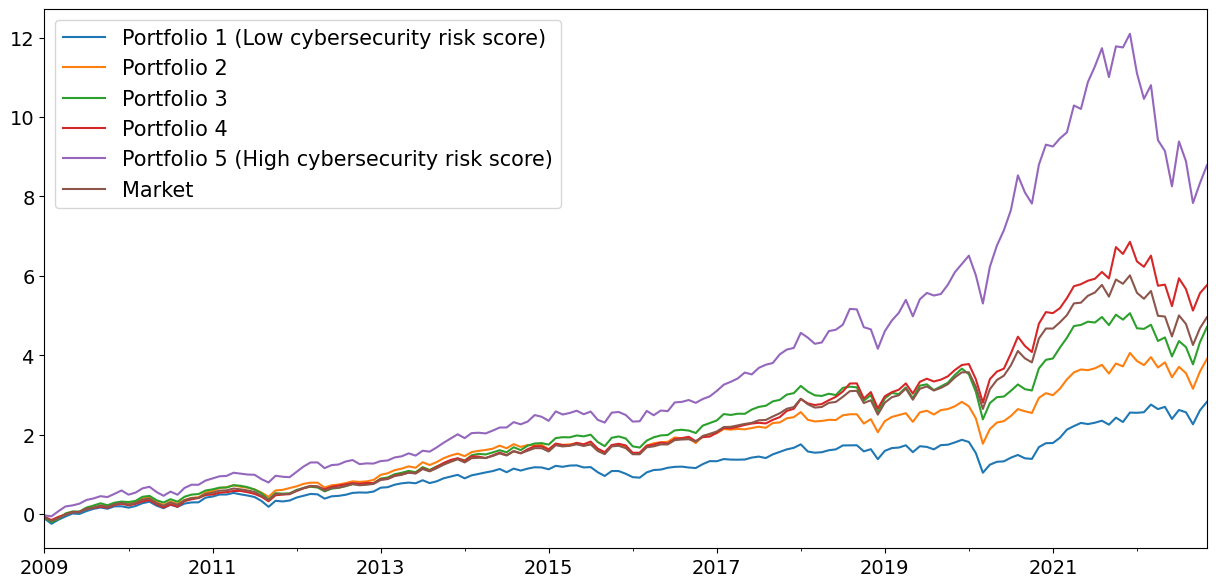

In [36]:
#plot the cumulative return of the quintile portfolios and the market portfolio
Mkt = FF5['Mkt-RF'].add(FF5['RF'])
Mkt.name = 'Mkt'
temp = pd.concat([vw_ret, Mkt[Mkt.index.isin(vw_ret.index)]], axis = 1)
#temp['LS'] = temp.quintile_4.sub(temp.quintile_0)
((temp+1).cumprod()-1).plot(figsize = (15,7))
#plt.title('Cumulative Returns', fontsize = 18)
plt.legend(['Portfolio 1 (Low cybersecurity risk score)', 'Portfolio 2', 'Portfolio 3',
            'Portfolio 4', 'Portfolio 5 (High cybersecurity risk score)',
            'Market'], fontsize = 15)#,'Long Short Portfolio (H-L)'
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [39]:
#value weighted excess returns and alphas
table, pval_table, t_stat_table, Ratio_table = get_alphas(vw_ret, FF5)
print('Value weighted portfolios')
display(table.style.format("{:.2%}"))
print('p-values:')
display(pval_table.style.format("{:.3f}"))
print('t stats:')
display(t_stat_table.style.format("{:.3f}"))
print('Annualized ratios:')
display(Ratio_table.style.format("{:.4}"))

Value weighted portfolios


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.88%,1.02%,1.13%,1.22%,1.45%,0.56%
CAPM alpha,-0.22%,-0.07%,-0.05%,0.08%,0.33%,0.55%
FFC alpha,-0.14%,-0.02%,0.03%,0.05%,0.25%,0.39%
FF5 alpha,-0.16%,-0.08%,0.03%,0.06%,0.26%,0.41%


p-values:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,0.001,0.000,0.000,0.000,0.000,0.081
CAPM alpha,0.346,0.659,0.697,0.165,0.095,0.179
FFC alpha,0.236,0.849,0.734,0.415,0.043,0.056
FF5 alpha,0.108,0.354,0.727,0.473,0.048,0.024


t stats:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Excess return,3.192,3.857,3.710,4.730,4.184,1.743
CAPM alpha,-0.942,-0.442,-0.390,1.388,1.671,1.343
FFC alpha,-1.185,-0.190,0.339,0.815,2.027,1.911
FF5 alpha,-1.605,-0.927,0.349,0.718,1.975,2.264


Annualized ratios:


,Q1 (low),Q2,Q3,Q4,Q5 (high),Q5-Q1
Annualized Sharpe Ratio,0.6375,0.772,0.796,0.903,1.049,0.6408
Annualized Treynor Ratio,0.03146,0.03695,0.03774,0.04233,0.05098,4.408
Annualized Sortino Ratio,0.9419,1.196,1.253,1.483,1.812,2.759


In [38]:
#characteristics of the portfolios
tableB = pd.DataFrame(np.ones([2,5]), index = ['Number of firms', 'Cyber risk index'],
                      columns = ['Q1 (low)', 'Q2', 'Q3', 'Q4', 'Q5 (high)'])
tableB.loc['Number of firms',:] = np.mean(nb_firms, axis = 0)
tableB.loc['Cyber risk index',:] = np.mean(risk_index_quintiles, axis = 0)

tableB.style.format("{:.3f}")

,Q1 (low),Q2,Q3,Q4,Q5 (high)
Number of firms,611.929,611.286,611.250,611.286,611.696
Cyber risk index,0.493,0.507,0.518,0.532,0.571
